In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statistics import mean
from random import randint

import pandas as pd
import numpy as np

### Datasets

In [13]:
heart_df = pd.read_csv('./data/SAheart.data')
heart_df.replace({'famhist': {'Absent': 0, 'Present': 1}}, inplace=True)
heart_df.drop(columns=['row.names'], inplace=True)
heart_df.head()

/tmp/ipykernel_9590/589209571.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heart_df.replace({'famhist': {'Absent': 0, 'Present': 1}}, inplace=True)


,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,1,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,0,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,1,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,1,60,25.99,57.34,49,1


In [9]:
fitness_df = pd.read_csv('./data/fitness.txt', sep='\\s+')
fitness_df.head()

,Age,Weight,Oxygen,RunTime,RestPulse,RunPulse,MaxPulse
0,44,89.47,44.609,11.37,62,178,182
1,44,85.84,54.297,8.65,45,156,168
2,38,89.02,49.874,9.22,55,178,180
3,40,75.98,45.681,11.95,70,176,180
4,44,81.42,39.442,13.08,63,174,176


### Bagging Decision Tree class

In [67]:
class BaggingDecisionTree():
    def __init__(self, tree_type, n_trees):
        
        if tree_type == DecisionTreeClassifier:
            self.criterion = "entropy"
        elif tree_type == DecisionTreeRegressor:
            self.criterion = "squared_error"
        else:
            raise Exception("Invalid tree type! Choose between: \
                (DecisionTreeClassifier, DecisionTreeRegressor)")
        
        self.tree = tree_type
        self.n_trees = n_trees
        self.models = []
            
    def __bootstrap(self, X, y):
        df_size = len(X)
        
        sample_X = []
        sample_y = []
        
        for _ in range(df_size):
            idx = randint(0, df_size - 1)
            
            sample_X.append(X[idx])
            sample_y.append(y[idx])
            
        sample_X = np.array(sample_X)
        sample_y = np.array(sample_y)
            
        # sample_X = pd.DataFrame(sample_X, columns=list(X.columns))
        # sample_y = pd.DataFrame(sample_y, columns=[y.name])
        
        return sample_X, sample_y
        
            
    def fit(self, X, y):
        for _ in range(self.n_trees):
            sample_X, sample_y = self.__bootstrap(X, y)
            
            model = self.tree(criterion=self.criterion)
            model.fit(sample_X, sample_y)
            self.models.append(model)
    
    def __score_classifier(self, X, y):
        preds = np.array([model.score(X, y) for model in self.models])
        return (round(mean(preds)))
        
    def __score_regressor(self, X, y):
        preds = np.array([model.score(X, y) for model in self.models])
        return mean(preds)
    
    def score(self, X, y):
        if len(self.models) == 0:
            raise Exception("Models need to be trained at first!")
        
        if self.tree == DecisionTreeClassifier:
            return self.__score_classifier(X, y)
        elif self.tree == DecisionTreeRegressor:
            return self.__score_regressor(X, y)


## Experiments

In [111]:
test_sizes = [0.1, 0.2, 0.25, 0.3, 0.4]

X = heart_df[heart_df.columns.drop('chd')].to_numpy()
y = heart_df['chd'].to_numpy()

### South African Heart Disease dataset

#### Single tree

In [112]:
total_acc_single = []

for test_size in test_sizes:

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    model = DecisionTreeClassifier(criterion="entropy")
    model.fit(X_train, y_train)

    acc = model.score(X_test, y_test)
    total_acc_single.append(acc)
    
    print(f"Test size: {test_size}\tSingle tree accuracy: {round(acc, 2)}")
    
print(f"Mean accuracy for single tree: {round(mean(total_acc_single), 2)}")

Test size: 0.1	Single tree accuracy: 0.68
Test size: 0.2	Single tree accuracy: 0.72
Test size: 0.25	Single tree accuracy: 0.59
Test size: 0.3	Single tree accuracy: 0.59
Test size: 0.4	Single tree accuracy: 0.64
Mean accuracy for single tree: 0.64


#### Bagging

In [129]:
total_acc_bagging = []

for test_size in test_sizes:

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    model = BaggingDecisionTree(DecisionTreeClassifier, 10)
    model.fit(X_train, y_train)

    acc = model.score(X_test, y_test)
    total_acc_bagging.append(acc)
    
    print(f"Test size: {test_size}\tBagging tree accuracy: {round(acc, 2)}")
    
print(f"Mean accuracy for bagging tree: {round(mean(total_acc_bagging), 2)}")

Test size: 0.1	Bagging tree accuracy: 1
Test size: 0.2	Bagging tree accuracy: 1
Test size: 0.25	Bagging tree accuracy: 1
Test size: 0.3	Bagging tree accuracy: 1
Test size: 0.4	Bagging tree accuracy: 1
Mean accuracy for bagging tree: 1


### Plot to compare performance

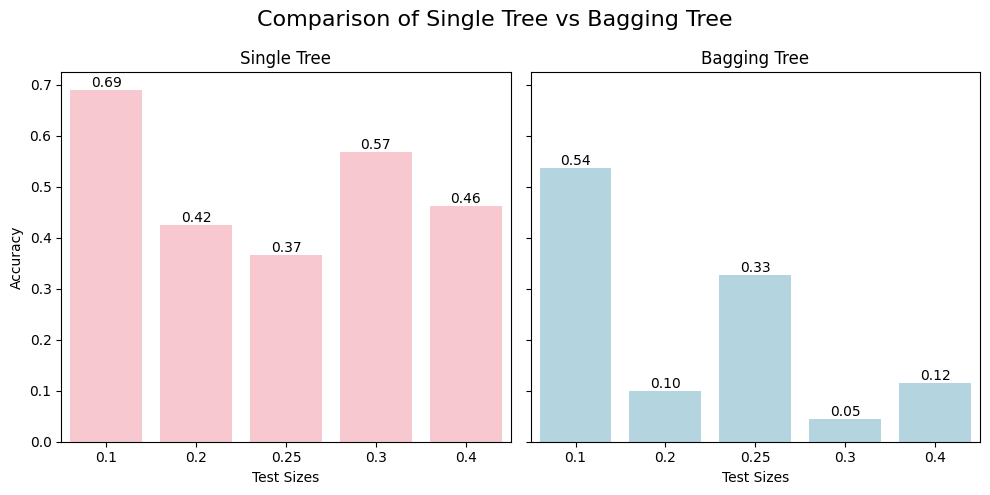

In [211]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)

sns.barplot(x=test_sizes, y=total_acc_single, color='pink',  ax=axes[0])
axes[0].set_title('Single Tree') 
axes[0].set_xlabel('Test Sizes') 
axes[0].set_ylabel('Accuracy')  
axes[0].bar_label(axes[0].containers[0], fontsize=10, fmt='%.2f')


sns.barplot(x=test_sizes, y=total_acc_bagging, color='lightblue', ax=axes[1])
axes[1].set_title('Bagging Tree')
axes[1].set_xlabel('Test Sizes') 
axes[1].set_ylabel('Accuracy')
axes[1].bar_label(axes[1].containers[0], fontsize=10, fmt='%.2f') 

fig.suptitle('Comparison of Single Tree vs Bagging Tree', fontsize=16)

plt.tight_layout()  
plt.show()

### Fitness dataset

In [141]:
X = fitness_df[fitness_df.columns.drop('Oxygen')].to_numpy()
y = fitness_df['Oxygen'].to_numpy()

#### Single tree

In [144]:
total_acc_single = []

for test_size in test_sizes:

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    model = DecisionTreeRegressor(criterion="squared_error")
    model.fit(X_train, y_train)

    acc = model.score(X_test, y_test)
    total_acc_single.append(acc)
    
    print(f"Test size: {test_size}\tSingle tree R^2 score: {round(acc, 2)}")
    
print(f"Mean R^2 score for single tree: {round(mean(total_acc_single), 2)}")

Test size: 0.1	Single tree R^2 score: 0.69
Test size: 0.2	Single tree R^2 score: 0.42
Test size: 0.25	Single tree R^2 score: 0.37
Test size: 0.3	Single tree R^2 score: 0.57
Test size: 0.4	Single tree R^2 score: 0.46
Mean R^2 score for single tree: 0.5


#### Bagging

In [202]:
total_acc_bagging = []

for test_size in test_sizes:

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    model = BaggingDecisionTree(DecisionTreeRegressor, 10)
    model.fit(X_train, y_train)
    
    acc = model.score(X_test, y_test)
    total_acc_bagging.append(acc)
    
    print(f"Test size: {test_size}\tBagging tree R^2 score: {round(acc, 2)}")
    
print(f"Mean R^2 score for bagging tree: {round(mean(total_acc_bagging), 2)}")

Test size: 0.1	Bagging tree R^2 score: 0.54
Test size: 0.2	Bagging tree R^2 score: 0.1
Test size: 0.25	Bagging tree R^2 score: 0.33
Test size: 0.3	Bagging tree R^2 score: 0.05
Test size: 0.4	Bagging tree R^2 score: 0.12
Mean R^2 score for bagging tree: 0.22


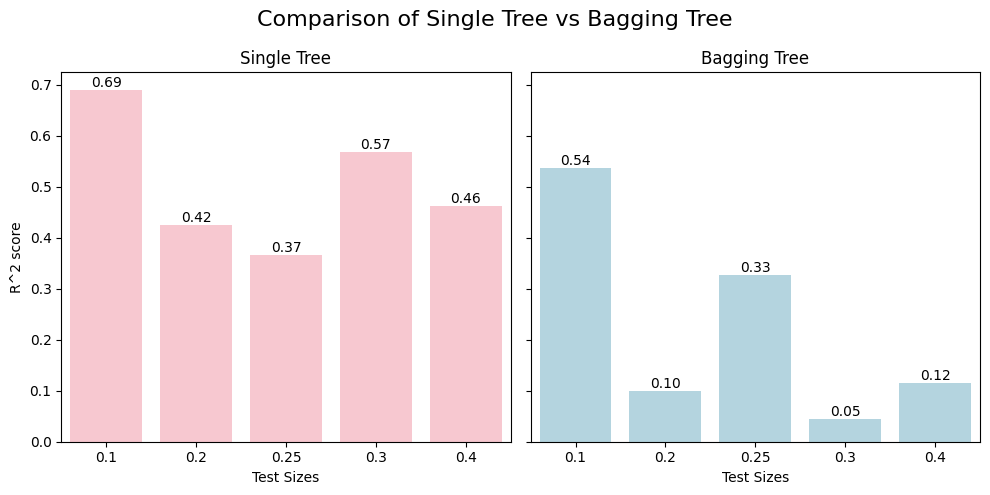

In [210]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)

sns.barplot(x=test_sizes, y=total_acc_single, color='pink',  ax=axes[0])
axes[0].set_title('Single Tree') 
axes[0].set_xlabel('Test Sizes') 
axes[0].set_ylabel('R^2 score')  
axes[0].bar_label(axes[0].containers[0], fontsize=10, fmt='%.2f')


sns.barplot(x=test_sizes, y=total_acc_bagging, color='lightblue', ax=axes[1])
axes[1].set_title('Bagging Tree')
axes[1].set_xlabel('Test Sizes') 
axes[1].set_ylabel('R^2 score')
axes[1].bar_label(axes[1].containers[0], fontsize=10, fmt='%.2f') 

fig.suptitle('Comparison of Single Tree vs Bagging Tree', fontsize=16)

plt.tight_layout()  
plt.show()